In [1]:
# Load libraries
import glob     
import numpy as np
import os

# manage file pathing
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Load pre-processing libraries
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import torch

# load custom libraries 
from src.pre_process_data import convert_all_images_from_png_to_jpg, build_train_df, process_data, stratified_random_shuffle_sampler
from src.model_training import load_pretrained_model
# load custom defined constants 
from model_config import CLASSES,WEIGHTS_CLASS_IMBALANCE,EARLYSTOP,OPTIMIZER,LR_SCHEDULER

# Visualisation
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set()
from sklearn.metrics import classification_report

# Constants
# Load the data path to images
IMG_DIR = '../data/train'
LABEL_FILENAME = 'labels.csv'

# Do note that since fixed seeds where not used there maybe viations in the exact values in terms of reproducibility.

# We will assume that all images are of .jpg or .png extensions

In [2]:
# convert any images that may be png
convert_all_images_from_png_to_jpg(IMG_DIR)
# generate train_df
train_df = build_train_df(IMG_DIR,LABEL_FILENAME)
print(train_df)
# show target names
CLASSES = list(train_df.category.unique())
print("Classes:", CLASSES)


No .png images found
           image  category
0    2788353.jpg         0
1    2782131.jpg         0
2    2884349.jpg         0
3    2900596.jpg         0
4    2841543.jpg         0
..           ...       ...
895  2804619.jpg         4
896  2829250.jpg         4
897  2825240.jpg         4
898  2825172.jpg         4
899  2847678.jpg         4

[900 rows x 2 columns]
           image
0    1003035.jpg
1    1005343.jpg
2    1008439.jpg
3    1015027.jpg
4    1056555.jpg
..           ...
895   964374.jpg
896   977738.jpg
897   980701.jpg
898   986137.jpg
899   997951.jpg

[900 rows x 1 columns]
           image  category
0    2788353.jpg         0
1    2782131.jpg         0
2    2884349.jpg         0
3    2900596.jpg         0
4    2841543.jpg         0
..           ...       ...
895  2804619.jpg         4
896  2829250.jpg         4
897  2825240.jpg         4
898  2825172.jpg         4
899  2847678.jpg         4

[900 rows x 2 columns]
Classes: [0, 1, 2, 3, 4]


In [3]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# We will process our data to ensure that the file format is appopropriate for pytorch's ImageFolder
if not 'processed_data' in next(os.walk(IMG_DIR))[1] or not [str(i) for i in CLASSES] == next(os.walk(f"{IMG_DIR}/processed_data/"))[1]:
    process_data(train_df,IMG_DIR,CLASSES)

PROCESSED_DATA_PATH = f"{IMG_DIR}/processed_data/"
BATCH_SIZE = 64

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(PROCESSED_DATA_PATH, transform=transform)
print(train_dataset)

# randomly split train and validation data, we could also do a simple splice of 0.7 train - 0.3 validation
# It is assumed that the class distribution of the test data will be similar to the class distribtion of the training data
train_sampler, valid_sampler = stratified_random_shuffle_sampler(train_dataset, test_size=0.3, shuffle=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              sampler=train_sampler)
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              sampler=valid_sampler)
train_size =  len(train_sampler)
valid_size = len(valid_sampler)

Dataset ImageFolder
    Number of datapoints: 900
    Root location: ../data/train/processed_data/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomAffine(degrees=[-40.0, 40.0], scale=(1, 2), shear=[-15.0, 15.0])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


c:\Users\USER\Anaconda3\envs\money\lib\site-packages\torchvision\transforms\transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
c:\Users\USER\Anaconda3\envs\money\lib\site-packages\torchvision\transforms\transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


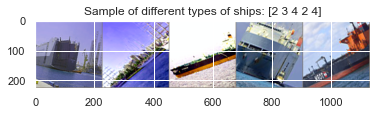

In [4]:
import torchvision
# Sample some of our training data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from subset of batch
out = torchvision.utils.make_grid(inputs[0:5])
imshow(out,title=f"Sample of different types of ships: {classes[0:5].numpy()}")

# Import and train model

In [9]:
# Use cuda to enable gpu usage for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# load model
model_ft = load_pretrained_model(model_name='vgg16', classes=CLASSES, device=device)
print(model_ft)

cuda
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [10]:
def weight_builder(IMG_DIR, clss_lst, data_size):
  weights = []
  for clss in clss_lst:
    num_of_samples = len(glob.glob(f"{IMG_DIR}/processed_data/{clss}/*jpg")) 
    weights.append(1 / (num_of_samples / data_size))
  return weights

class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [11]:
if WEIGHTS_CLASS_IMBALANCE:
    # Create weights to handle class imbalance (Used later)
    weights = weight_builder(IMG_DIR, CLASSES, train_size)
    print("Weight balanced is used.")
    print("Re-weight distribution:",weights)
    loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
else:
    print("No Weight balanced is used.")
    loss_fn = nn.CrossEntropyLoss()
if EARLYSTOP:
    print("Early stopping is enabled.")
    # Add early stopping as a regularizer for overfitting
    early_stopping = EarlyStopping(tolerance=5, min_delta=10)
if OPTIMIZER == 'Adam':
    print("Optimiser used:", OPTIMIZER)
    # We will use ADAM as our opitimiser to learn the optimal amount of gradient descent
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
else:
    print("Optimiser used: SGD")
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)
if LR_SCHEDULER == 'Step':
    print("learning rate scheduler used: Step")
    # Exponentially Decay LR by a factor of 0.1
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
else:
    print("lr scheduler not found")

No Weight balanced is used.
Early stopping is enabled.
Optimiser used: Adam
learning rate scheduler used: Step


In [12]:
import time
import copy
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=100):
    since = time.perf_counter()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.perf_counter() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3654 Acc: 0.4556
val Loss: 1.0287 Acc: 0.6185

Epoch 1/24
----------
train Loss: 0.9480 Acc: 0.6222
val Loss: 0.8520 Acc: 0.6593

Epoch 2/24
----------
train Loss: 0.8961 Acc: 0.6556
val Loss: 0.8509 Acc: 0.6778

Epoch 3/24
----------
train Loss: 0.8486 Acc: 0.6587
val Loss: 0.7889 Acc: 0.7222

Epoch 4/24
----------
train Loss: 0.8397 Acc: 0.6841
val Loss: 0.7913 Acc: 0.7185

Epoch 5/24
----------
train Loss: 0.7323 Acc: 0.7381
val Loss: 0.7188 Acc: 0.7259

Epoch 6/24
----------
train Loss: 0.7599 Acc: 0.7048
val Loss: 0.8223 Acc: 0.7407

Epoch 7/24
----------
train Loss: 0.7922 Acc: 0.6952
val Loss: 0.7213 Acc: 0.7259

Epoch 8/24
----------
train Loss: 0.7257 Acc: 0.7079
val Loss: 0.7617 Acc: 0.7259

Epoch 9/24
----------
train Loss: 0.7399 Acc: 0.7095
val Loss: 0.7213 Acc: 0.7148

Epoch 10/24
----------
train Loss: 0.7710 Acc: 0.6921
val Loss: 0.7446 Acc: 0.7148

Epoch 11/24
----------
train Loss: 0.7327 Acc: 0.7254
val Loss: 0.7574 Acc: 0.7259

Ep

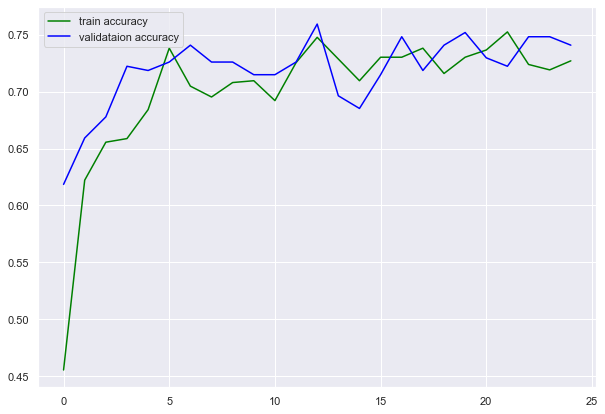

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('../images/train_val_accuracy.png')
plt.show()

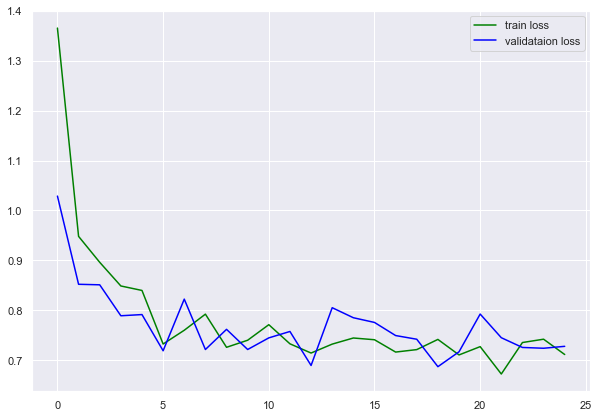

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train loss')
plt.plot(plot_val_loss, color='blue', label='validataion loss')
plt.legend()
plt.savefig('../images/train_val_loss.png')
plt.show()

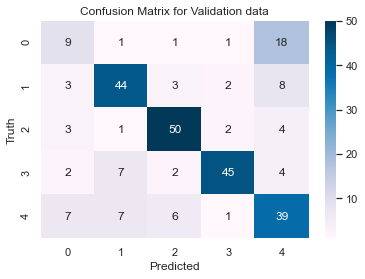

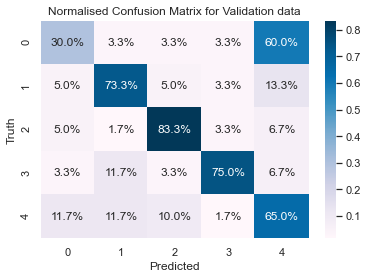

Analysis
Taking a look at our normalised confusion Model Evaluation, we see that many of the '0' class has been predicted as as the '4' class. As 60.0% of all Validation '0' classe was predicted as '4'. 
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        30
           1       0.73      0.73      0.73        60
           2       0.81      0.83      0.82        60
           3       0.88      0.75      0.81        60
           4       0.53      0.65      0.59        60

    accuracy                           0.69       270
   macro avg       0.67      0.65      0.66       270
weighted avg       0.70      0.69      0.69       270

The low precision score but high recall value for 0, could be due to '0' being a minority class, where there are fewer postive examples to become false negatives, while there are many negative examples that could become false positives


In [15]:
nb_classes = len(CLASSES)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
truth = []
pred = []


with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        pred.extend(preds.view(-1).tolist())
        truth.extend(classes.view(-1).tolist())
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

sns.heatmap(confusion_matrix, annot=True, cmap='PuBu')
plt.title("Confusion Matrix for Validation data")
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

normalised_cm = confusion_matrix.numpy()/np.sum(confusion_matrix.numpy(),axis=1)[:, np.newaxis]

sns.heatmap(normalised_cm,fmt='.1%', annot=True, cmap='PuBu')
plt.title("Normalised Confusion Matrix for Validation data")
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

print("Analysis")
print(f"Taking a look at our normalised confusion Model Evaluation, we see that many of the '0' class has been predicted as as the '4' class. As {round(normalised_cm[0][-1]*100,2)}% of all Validation '0' classe was predicted as '4'. ")

print(classification_report(truth, pred))

print("The low precision score but high recall value for 0, could be due to '0' being a minority class, where there are fewer postive examples to become false negatives, while there are many negative examples that could become false positives")

In [22]:
# saving model (TorchScript) Using TorchScript allows for simpler deployment
model_scripted = torch.jit.script(model_ft) # Export to TorchScript
try:
    os.makedirs(f"{IMG_DIR}/models/", exist_ok=False)
except:
    pass
model_scripted.save('../models/VGG16_v2_train.pt')

# saving model (state dict)
# torch.save(model_ft.state_dict(), '../models/VGG16_v4_class_weights.pt')

## Class Weights Model

In [19]:
# Load previously saved model
model_ft = torch.jit.load('../models/VGG16_v4_class_weights_export.pt')
model_ft.to(device)

RecursiveScriptModule(
  original_name=VGG
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
    (5): RecursiveScriptModule(original_name=Conv2d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=Conv2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=MaxPool2d)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Conv2d)
    (13): RecursiveScriptModule(original_name=ReLU)
    (14): RecursiveScriptModule(original_name=Conv2d)
    (15): RecursiveScriptModule(original_name=ReLU)
    (16): RecursiveScriptModule(original_name

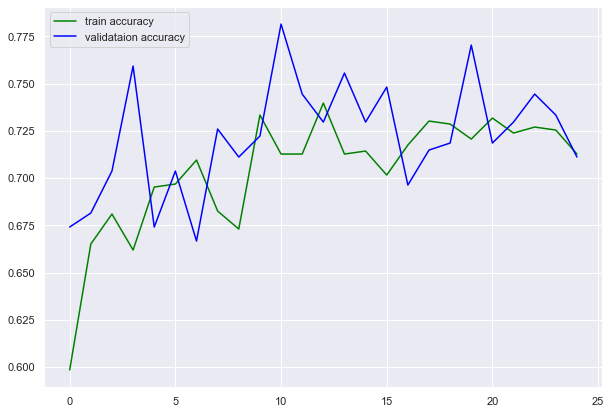

In [26]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.title("Train vs Validation accuracy")
plt.legend()
plt.savefig('../images/class_weight_train_val_accuracy.png')
plt.show()

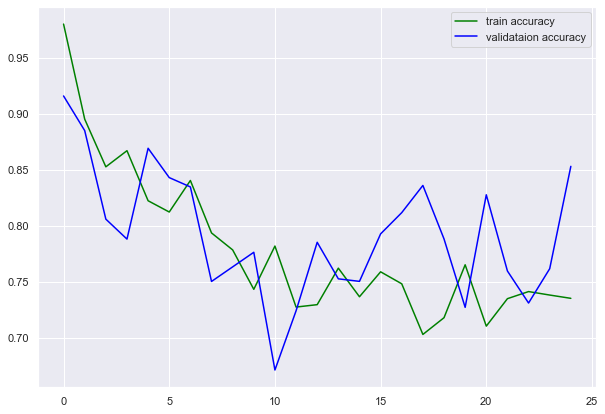

In [27]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train accuracy')
plt.plot(plot_val_loss, color='blue', label='validataion accuracy')
plt.title("Train vs Validation loss")
plt.legend()
plt.savefig('../images/class_weight_train_val_loss.png')
plt.show()

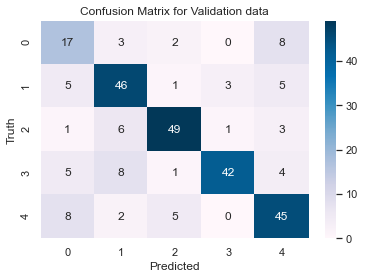

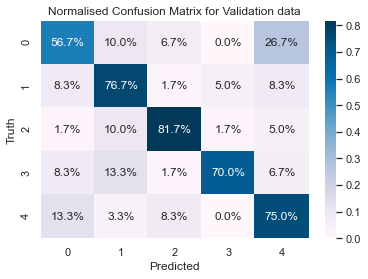

Confusion Matrix Analysis
We see that with re-balancing weights, there is a drop in misclassifications from the '0' class to the '4' class
              precision    recall  f1-score   support

           0       0.47      0.57      0.52        30
           1       0.71      0.77      0.74        60
           2       0.84      0.82      0.83        60
           3       0.91      0.70      0.79        60
           4       0.69      0.75      0.72        60

    accuracy                           0.74       270
   macro avg       0.73      0.72      0.72       270
weighted avg       0.75      0.74      0.74       270

Classification report Analysis
There are also improvements to the overal prediction of all classes


In [21]:
nb_classes = len(CLASSES)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
truth = []
pred = []


with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        pred.extend(preds.view(-1).tolist())
        truth.extend(classes.view(-1).tolist())
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

sns.heatmap(confusion_matrix, annot=True, cmap='PuBu')
plt.title("Confusion Matrix for Validation data")
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

normalised_cm = confusion_matrix.numpy()/np.sum(confusion_matrix.numpy(),axis=1)[:, np.newaxis]

sns.heatmap(normalised_cm,fmt='.1%', annot=True, cmap='PuBu')
plt.title("Normalised Confusion Matrix for Validation data")
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

print("Confusion Matrix Analysis")
print("We see that with re-balancing weights, there is a drop in misclassifications from the '0' class to the '4' class")

print(classification_report(truth, pred))

print('Classification report Analysis')
print("There are also improvements to the overal prediction of all classes")

# Future Work


There were many possibilities that could be worked towards in the future of this assessment project,
1. Class distribution 
- Other than the acquisition of more data, oversampling and undersampling methods could be employed to help with the class imbalance. More sophisticated methods could be the usage of GANs to artifically create more data for the minority class
2. Preprocessing
- Another way to look at this problem could be to see it as an object detection problem instead of a class detection problem, creating annotated boundary boxes would create a model that focuses on the boats in the image and reduce the misinformation from the non important background space. 
3. Models 
- A model training process could take place with this already created pipeline to test several SOTA models such as CNN-BERT or larger more complex models such as Resnet152.
- Additionally, a hyperparameter tuning process could take place to find the optimal optimizer, learning rate, learing rate schedular, loss function model paramters. 
4. Model Visualisation 
- A GUI using streamlit could be provided to the front end user to view new images and their respective predicted classes 

In [19]:
import torch
from PIL import Image
import torchvision.transforms as transforms
  
# Read a PIL image
image = Image.open("../data/train/563043.jpg")
  
# Define a transform to convert PIL 
# image to a Torch tensor
transform = transforms.Compose([
    transforms.PILToTensor()
])
  
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(image)
  
import numpy
# print the converted Torch tensor
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
img_tensor.numpy()

array([[[166, 164, 165, 164, 161, 165, 167, 161, 167, 167, 167, 167,
         168, 167, 167, 167, 173, 173, 173, 173, 172, 172, 172, 172,
         173, 172, 172, 172, 172, 172, 173, 173, 176, 177, 177, 178,
         178, 178, 177, 177, 177, 183, 181, 174, 181, 184, 174, 179,
         175, 176, 177, 176, 176, 176, 176, 177, 177, 177, 178, 178,
         178, 178, 177, 177, 180, 179, 179, 179, 179, 179, 179, 178,
         178, 179, 180, 181, 182, 182, 183, 183, 181, 182, 182, 180,
         181, 183, 183, 182, 182, 182, 182, 182, 182, 183, 183, 183,
         184, 184, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185,
         186, 186, 186, 186, 184, 185, 186, 186, 186, 186, 185, 184,
         184, 183, 183, 183, 183, 183, 183, 184, 181, 182, 183, 184,
         184, 184, 183, 183, 182, 182, 182, 183, 183, 183, 184, 184,
         184, 184, 185, 185, 185, 185, 184, 184, 184, 183, 183, 183,
         182, 182, 182, 181, 182, 183, 183, 183, 183, 183, 183, 182,
         183, 183, 183, 182, 182, 